## 26단계: 계산 그래프 시각화(2)

> 이번 단계에서는 DeZero 계산 그래프를 DOT 언어로 변환하려 합니다. 구체적으로는 DeZero에서 실행한 계산을 DOT 언어로 변환하는 기능을 구현할 것입니다.

### 26.1 시각화 코드 예

시각화 코드를 작성하여 실행하면 다음과 같은 그래프를 얻을 수 있을 것이다.

<img src="images/그림 26-1.png" width=250/>

### 26.2 계산 그래프에서 DOT 언어로 변환하기

`_dot_var` 보조 함수를 `dezero/utils.py`에 구현한다.

In [1]:
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=filled]\n'
    
    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ': '
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)

# 사용 예
import numpy as np
from dezero import Variable

x = Variable(np.random.randn(2, 3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

140277729255952 [label="x", color=orange, style=filled]

140277729255952 [label="x: (2, 3) float64", color=orange, style=filled]



이어서 'DeZero 함수'를 DOT 언어로 변환하는 편의 함수(`_dot_func`)를 구현하겠다.

In [2]:
def _dot_func(f):
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    txt = dot_func.format(id(f), f.__class__.__name__)
    
    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y.__repr__.__self__))  # due to weakref.proxy
    return txt

# 사용 예
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

140277727845584 [label="Add", color=lightblue, style=filled, shape=box]
140277728732144 -> 140277727845584
140277727841456 -> 140277727845584
140277727845584 -> 140277727948160



다음으로, Variable 클래스의 backward 매서드를 참고하여 `get_dot_graph` 함수를 구현한다.

In [3]:
def get_dot_graph(output, verbose=False):
    txt = ''
    funcs = []
    seen_set = set()
    
    def add_func(f):
        if f not in seen_set:
            funcs.append(f)
            seen_set.add(f)
    
    add_func(output.creator)
    txt = _dot_var(output, verbose)
    
    while funcs:
        f = funcs.pop()
        txt += _dot_func(f)
        for x in f.inputs:
            txt += _dot_var(x, verbose)
            
            if x.creator is not None:
                add_func(x.creator)
    
    return 'digraph g {\n' + txt + '}'

### 26.3 이미지 변환까지 한 번에

`get_dot_graph` 함수는 계산 그래프를 DOT 언어로 변환한다. 그러나 이미지를 보려면 터미널에서 `dot`명령어를 실행해야 하니 번거롭다. 따라서 `dot`명령까지 실행해주는 함수를 제공해보자.

In [4]:
import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)

    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')
    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

    with open(graph_path, 'w') as f:
        f.write(dot_graph)

    extension = os.path.splitext(to_file)[1][1:]  # Extension(e.g. png, pdf)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)

    # Return the image as a Jupyter Image object, to be displayed in-line.
    try:
        from IPython import display
        return display.Image(filename=to_file)
    except:
        pass

### 26.4 동작 확인

24단계의 Goldstein-Price 함수를 시각화해보자.

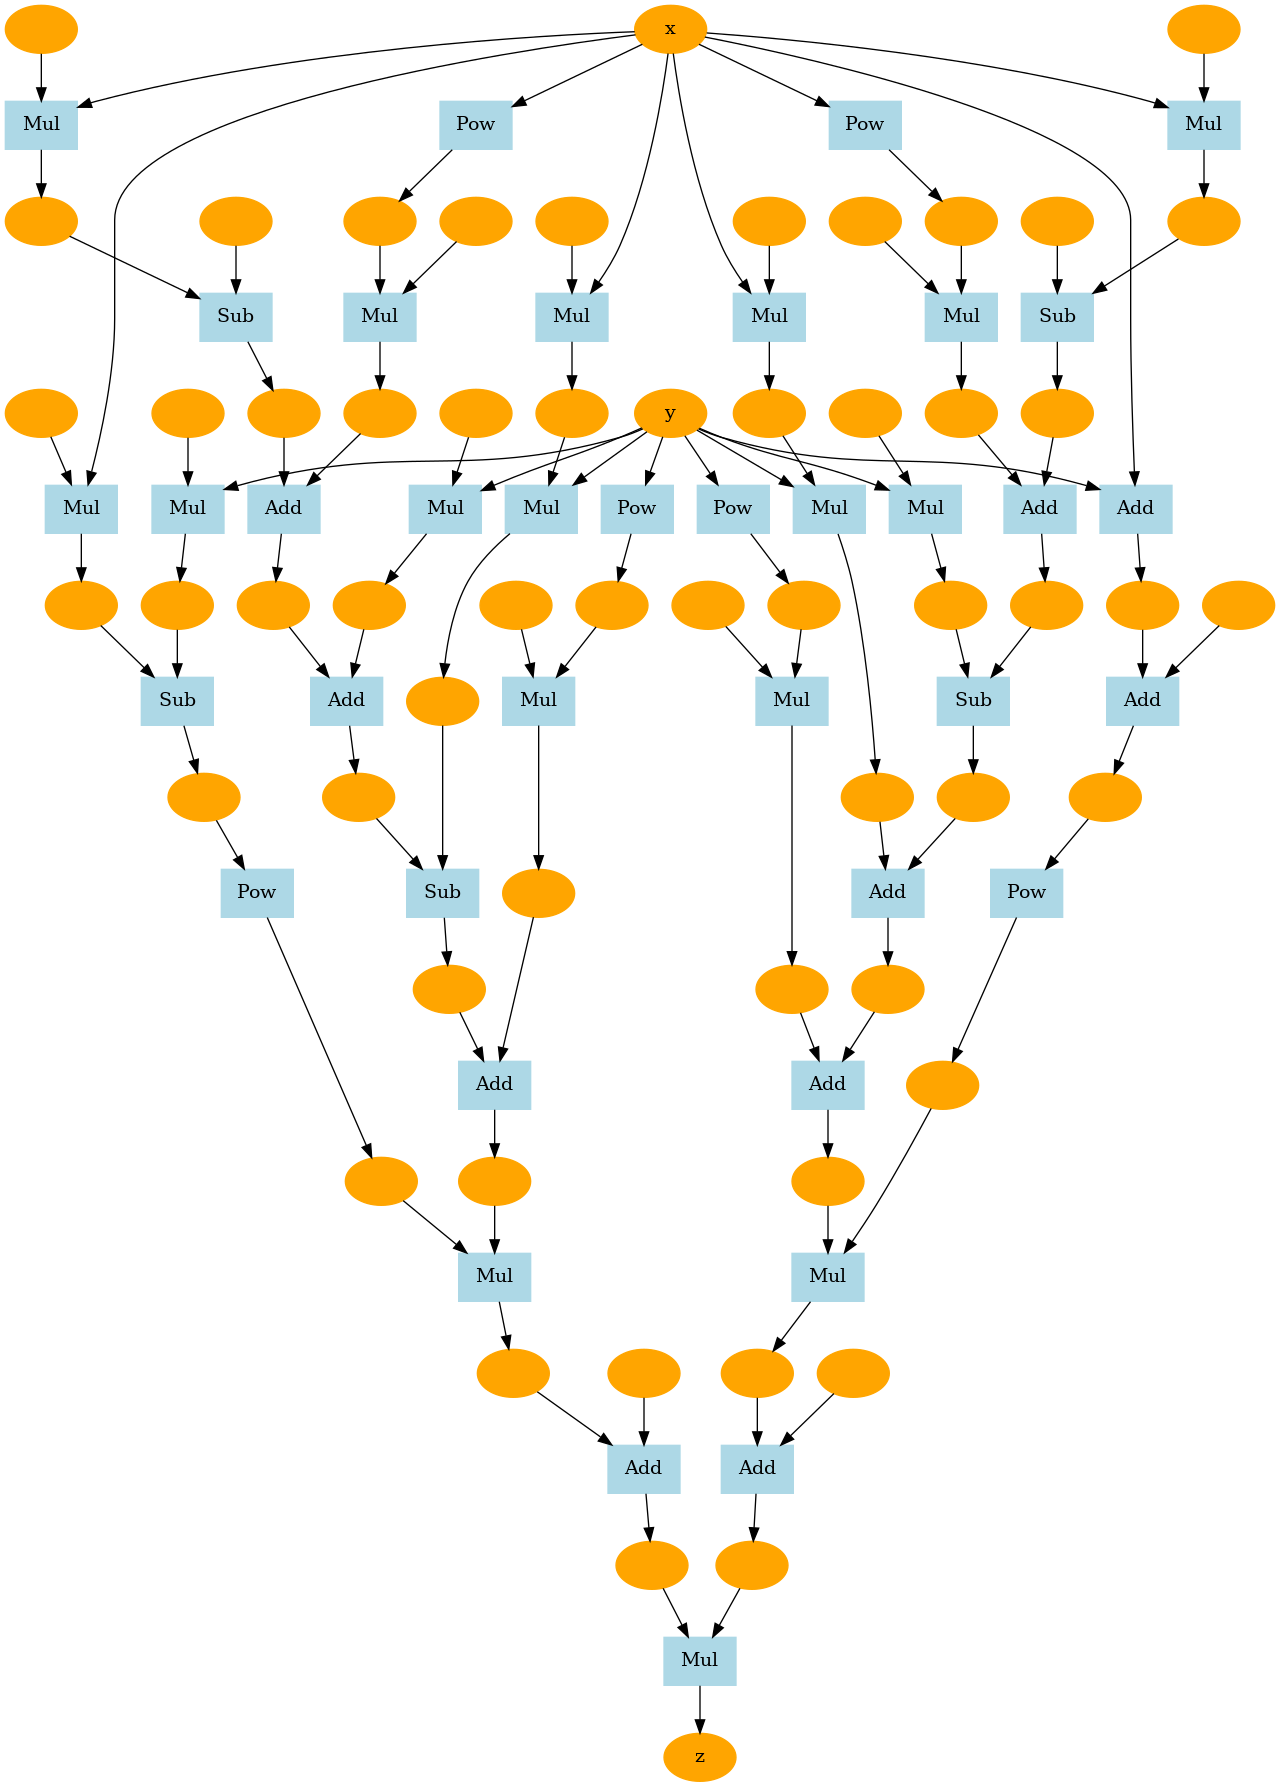

In [5]:
import numpy as np
from dezero import Variable
# from dezero.utils import plot_dot_graph

def goldstein(x, y):
    return (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

이상으로 계산 그래프 시각화를 마친다.